In [145]:
# https://platform.olimpiada-ai.ro/problems/42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [146]:
train = pd.read_csv("/kaggle/input/automated-loan-evaluation-system/train.csv")
test = pd.read_csv("/kaggle/input/automated-loan-evaluation-system/test.csv")

In [147]:
train.head(3)

,customer_id,age,occupation_status,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,product_type,loan_intent,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
0,CUST116708,40,Self-Employed,14.1,77335,679,4.4,67,17026,0,0,0,Personal Loan,Education,26200,12.04,0.220,0.339,0.113,1
1,CUST109237,18,Employed,0.0,34946,639,1.2,292,2620,0,1,0,Personal Loan,Education,37400,14.95,0.075,1.070,0.357,0
2,CUST102214,29,Employed,9.4,26778,595,5.5,191,4702,1,1,0,Personal Loan,Personal,52300,15.51,0.176,1.953,0.651,0


In [148]:
cat_features = ['occupation_status', 'product_type', 'loan_intent']

# train = pd.get_dummies(train, columns=cat_features, dtype=float)
# test = pd.get_dummies(test, columns=cat_features, dtype=float)

In [149]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns_to_scale = ['age', 'years_employed', 'annual_income', 'credit_score', 'credit_history_years',
                    'savings_assets', 'current_debt', 'loan_amount', 'interest_rate', 'debt_to_income_ratio',
                    'loan_to_income_ratio', 'payment_to_income_ratio']

for col in columns_to_scale:
    train[col] = np.log10(train[col]*100+1)

scaler.fit(train[columns_to_scale])

train[columns_to_scale] = scaler.transform(train[columns_to_scale])
test[columns_to_scale] = scaler.transform(test[columns_to_scale])

In [150]:
from sklearn.model_selection import train_test_split

features = [c for c in train.columns if c not in ['customer_id', 'loan_status']]
cat_features = ['occupation_status', 'product_type', 'loan_intent']

X, y = train[features], train['loan_status']
X_test = test[features]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.1)

In [151]:
from catboost import Pool, CatBoostClassifier

train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=1000,
    loss_function='Logloss',
    eval_metric='AUC',
    metric_period=50,
    max_depth=4,
    random_state=42
)

model.fit(train_pool, eval_set=valid_pool)

Learning rate set to 0.076792
0:	test: 0.8608925	best: 0.8608925 (0)	total: 24.5ms	remaining: 24.4s
50:	test: 0.9770871	best: 0.9770871 (50)	total: 1.01s	remaining: 18.7s
100:	test: 0.9816776	best: 0.9816776 (100)	total: 2.01s	remaining: 17.9s
150:	test: 0.9835570	best: 0.9835570 (150)	total: 3s	remaining: 16.9s
200:	test: 0.9849578	best: 0.9849578 (200)	total: 3.96s	remaining: 15.8s
250:	test: 0.9857522	best: 0.9857522 (250)	total: 4.91s	remaining: 14.7s
300:	test: 0.9860686	best: 0.9860686 (300)	total: 5.85s	remaining: 13.6s
350:	test: 0.9863778	best: 0.9863778 (350)	total: 6.82s	remaining: 12.6s
400:	test: 0.9864379	best: 0.9864379 (400)	total: 7.77s	remaining: 11.6s
450:	test: 0.9865412	best: 0.9865412 (450)	total: 8.75s	remaining: 10.7s
500:	test: 0.9865725	best: 0.9865725 (500)	total: 9.75s	remaining: 9.71s
550:	test: 0.9865730	best: 0.9865730 (550)	total: 10.7s	remaining: 8.75s
600:	test: 0.9865309	best: 0.9865730 (550)	total: 11.8s	remaining: 7.83s
650:	test: 0.9865190	best: 0.

AUC Score: 0.98661


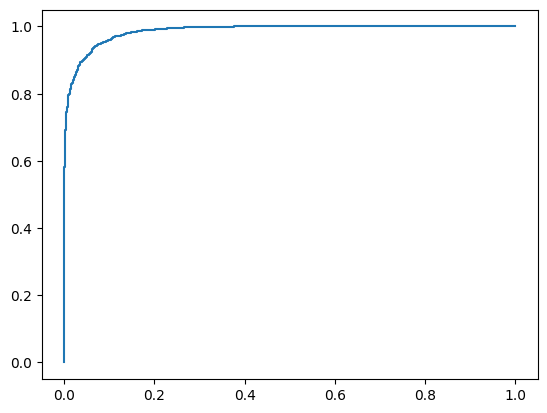

In [152]:
from sklearn.metrics import roc_curve, auc

y_pred = model.predict_proba(X_valid)[:, 1]

fpr, tpr, _ = roc_curve(y_valid, y_pred)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr)

print(f"AUC Score: {auc_score:.5f}")

plt.show()

In [153]:
test = pd.read_csv("/kaggle/input/automated-loan-evaluation-system/test.csv")
y_pred = model.predict(X_test)

result = []

for i, cid in tqdm(enumerate(test['customer_id']), total=10000):
    for sid in range(1, 5):
        age = test.loc[i, 'age']
        dtir = test.loc[i, 'debt_to_income_ratio']
        tot_obl = sum(test.loc[i, ['current_debt', 'derogatory_marks', 'delinquencies_last_2yrs']])
        pred = y_pred[i]

        if sid==1:
            if age < 30:
                ans = 'Young'
            elif 30 <= age < 60:
                ans = 'Adult'
            else:
                ans = 'Senior'
        elif sid==2:
            if dtir < 20:
                ans = 'LowRisk'
            elif 20 <= dtir < 40:
                ans = 'MediumRisk'
            else:
                ans = 'HighRisk'
        elif sid==3:
            ans = tot_obl
        else:
            ans = pred
        
        result.append({
            'subtaskID': sid,
            'datapointID': cid,
            'answer': ans
        })

subm = pd.DataFrame(result)

subm

  0%|          | 0/10000 [00:00<?, ?it/s]

,subtaskID,datapointID,answer
0,1,CUST146767,Adult
1,2,CUST146767,LowRisk
2,3,CUST146767,4276
3,4,CUST146767,1
4,1,CUST136829,Adult
...,...,...,...
39995,4,CUST127749,1
39996,1,CUST133393,Adult
39997,2,CUST133393,LowRisk
39998,3,CUST133393,24979


In [154]:
subm.to_csv("submission.csv", index=False)